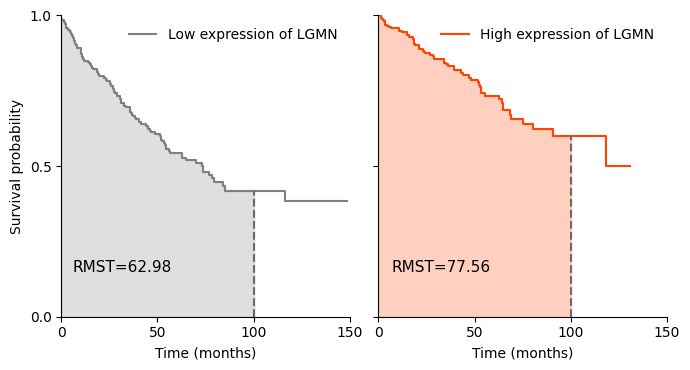

In [84]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter
from lifelines.utils import restricted_mean_survival_time


df = pd.read_csv('../cluster_compute/data/TCGA-KIRC.csv', sep=',')
df['time'] = df['time'] / 30.5

gene_a = 'LGMN'
gene_b = 'CD14'
interaction = f'{gene_a}-{gene_b}'

median_gene_a = df[gene_a].median()
gene_a_low = df[gene_a] <= median_gene_a
gene_a_high = df[gene_a] > median_gene_a


def rmst_plot(model, model2=None, t=np.inf, ax=None, text_position=None, **plot_kwargs):
    """this part of the code is taken from lifelines.plotting and adopted for the needs of our figure"""

    if ax is None:
        ax = plt.gca()

    rmst = restricted_mean_survival_time(model, t=t)
    c = plot_kwargs.pop("c", None)
    model.plot_survival_function(ax=ax, color=c, ci_show=False, **plot_kwargs)

    if text_position is None:
        text_position = (np.percentile(model.timeline, 10), 0.15)

    if model2 is not None:
        # c2 = ax._get_lines.get_next_color()
        c = 'orangered'
        rmst2 = restricted_mean_survival_time(model2, t=t)
        model2.plot_survival_function(ax=ax, color=c, ci_show=False, **plot_kwargs)
        timeline = np.unique(model.timeline.tolist() + model2.timeline.tolist() + [t])
        predict1 = model.predict(timeline).loc[:t]
        predict2 = model2.predict(timeline).loc[:t]

        ax.fill_between(
            timeline[timeline <= t],
            predict1,
            predict2,
            where=predict1 > predict2,
            step="post",
            color="grey", alpha=0.25,
            edgecolor="grey",
        )

        ax.fill_between(
            timeline[timeline <= t],
            predict1,
            predict2,
            where=predict1 < predict2,
            step="post",
            color="grey", alpha=0.25,
            edgecolor="grey",
        )

        y_val = model.predict(t)
        y_val2 = model2.predict(t)
        ax.axvline(t, 0, y_val2, ls="--", color="dimgray", alpha=1)
    else:
        rmst = restricted_mean_survival_time(model, t=t)
        sf_exp_at_limit = model.predict(np.append(model.timeline, t)).sort_index().loc[:t]
        ax.fill_between(sf_exp_at_limit.index, sf_exp_at_limit.values, step="post", color=c, alpha=0.25)
        ax.text(text_position[0], text_position[1], "RMST=%.2f" % rmst, fontsize=11)  # dynamically pick this.

        y_val = model.predict(t)
        ax.axvline(t, 0, y_val, ls="--", color="dimgray", alpha=1)

    ax.set_ylim(0, 1)
    return ax


time = 100

kmf = KaplanMeierFitter()
kmf_low = kmf.fit(df['time'][gene_a_low], df['event'][gene_a_low], label=f'Low expression of {gene_a}')
rmst_low = restricted_mean_survival_time(kmf_low, t=time)

kmf = KaplanMeierFitter()
kmf_high = kmf.fit(df['time'][gene_a_high], df['event'][gene_a_high], label=f'High expression of {gene_a}')
rmst_high = restricted_mean_survival_time(kmf_high, t=time)



fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(7, 3.8))

rmst_plot(kmf_low, t=time, c='gray', ax=ax[0])
ax[0].set_yticks([0, 0.5, 1])
ax[0].margins(x=0)
ax[0].spines['top'].set_visible(False) 
ax[0].spines['right'].set_visible(False) 
ax[0].legend(loc='upper right', frameon=False)
ax[0].set_ylabel("Survival probability")
ax[0].set_xlabel("Time (months)")


ax[0].set_xticks([0, 50, 100, 150])

rmst_plot(kmf_high, t=time, ax=ax[1], c='orangered')
ax[1].set_yticks([0, 0.5, 1])
ax[1].margins(x=0)
ax[1].set_yticklabels([])

ax[1].set_xticks([0, 50, 100, 150])

ax[1].spines['top'].set_visible(False) 
ax[1].spines['right'].set_visible(False) 
ax[1].legend(loc='upper right', frameon=False)
ax[1].set_xlabel("Time (months)")

fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
plt.savefig('figure2_rmst_example.pdf', dpi=300)

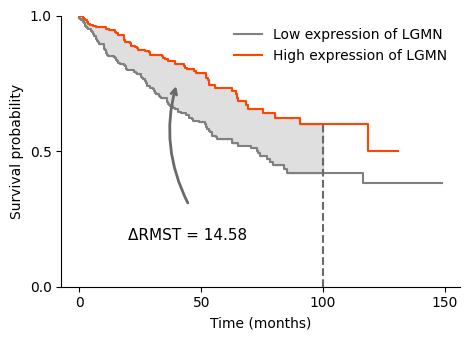

In [85]:
from matplotlib.patches import FancyArrowPatch

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4.8, 3.5)) # figsize=(5, 3.2)

rmst_plot(kmf_low, model2=kmf_high, t=time, ax=ax, c='gray')

arrow = FancyArrowPatch((45, 0.3), (40, 0.75), connectionstyle="arc3,rad=-.2", mutation_scale = 10, arrowstyle='->', lw=2, zorder=10, color='dimgray')
ax.add_patch(arrow)
ax.text( 20, 0.19, f"ΔRMST = {abs(round(rmst_high - rmst_low, 2))}", fontsize=11, ha='left', va='center', zorder=10)
ax.set_yticks([0, 0.5, 1])
ax.set_xticks([0, 50, 100, 150])
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 
ax.legend(loc='upper right', frameon=False)
ax.set_ylabel("Survival probability")
ax.set_xlabel("Time (months)")

fig.tight_layout()
plt.savefig('figure3_delta_rmst.pdf', dpi=300)
